# Markov chain Monte Carlo: Metropolis Hastings

In [1]:
import hypothesis
import matplotlib.pyplot as plt

from hypothesis.inference.mcmc import MetropolisHastings

As in every Bayesian inference setting we have to define a prior $p(\theta)$, which is in our case $\mathcal{U}(-50, 50)$.

In [2]:
from torch.distributions.uniform import Uniform

prior = Uniform(-50, 50)

The Metropolis-Hastings sampler needs a proposal (or transition) mechanism to propose states $\theta'$. This can be done using a *transition distribution*. As the target space is univariate, we simply import a `NormalTransition` to generate proposals.

In [3]:
from hypothesis.inference.transition_distribution import Normal as NormalTransition

transition = NormalTransition(1)

The likelihood of the generating process is normal. The log likelihood function in Hypothesis' MCMC samplers accept a parameter $\theta$ (tensor) and a tensor of observations.

In [4]:
from torch.distributions.normal import Normal

def log_likelihood(theta, observations):
    return Normal(theta, 1).log_prob(observations).sum()

We draw an observation from the forward model using an assumed truth:

In [5]:
truth = 0.
observations = Normal(truth, 1).sample().view(-1, 1)

We setup the Metropolis Hastings sampler using the components specified above:

In [6]:
sampler = MetropolisHastings(prior, log_likelihood, transition)

First, we need to let the Markov chain converge to its stationary distribution. This can be achieved using a *burnin chain*.

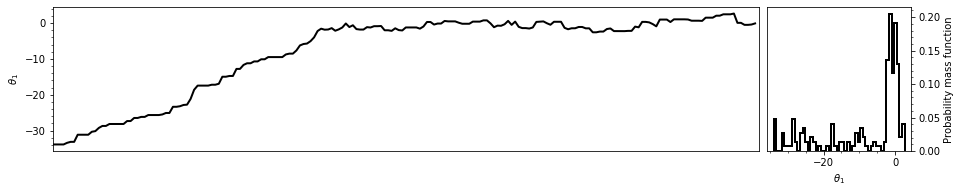

In [7]:
from hypothesis.visualization.mcmc import plot_trace

theta = prior.sample()
burnin_chain = sampler.sample(observations, theta, num_samples=200)

figure = plot_trace(burnin_chain)
plt.show()

Finally, after the burnin chain converged to its stationary distribution, we let the MetropolisHastings draw samples from the posterior.

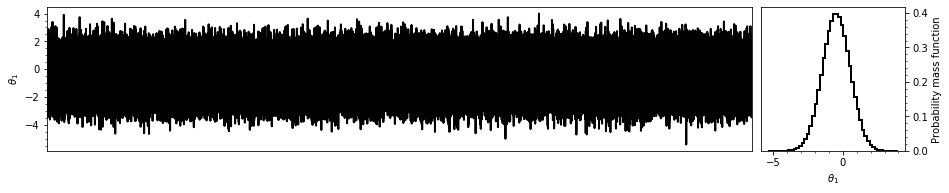

In [8]:
theta = burnin_chain[-1]
chain = sampler.sample(observations, theta, num_samples=1000000)

figure = plot_trace(chain)
plt.show()

The chain's autocorrelation:

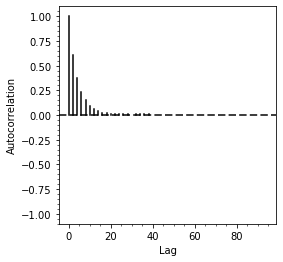

In [9]:
from hypothesis.visualization.mcmc import plot_autocorrelation

figure = plot_autocorrelation(chain, max_lag=100)
plt.show()

And the effective size (taking the Chain's autocorrelation into account):

In [10]:
print("Effective size:", chain.effective_size())
print("Sampling efficiency:", chain.efficiency())

Effective size: 208052
Sampling efficiency: 0.208052


Let's thin the chain. By default, a `proportion` equal to the sampling efficiency will be subsampled.

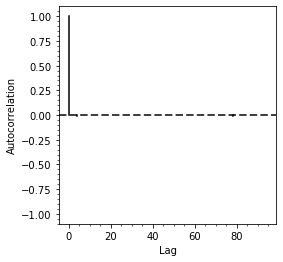

Effective size: 208052
Sampling efficiency: 1.0


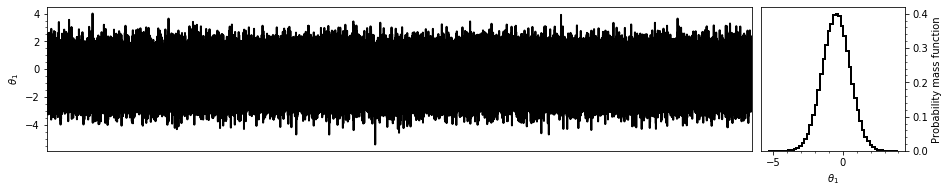

In [11]:
thinned_chain = chain.thin(proportion=chain.efficiency()) # Default behaviour, chain.thin() is equivalent.
figure = plot_autocorrelation(thinned_chain)
plt.show()

print("Effective size:", thinned_chain.effective_size())
print("Sampling efficiency:", thinned_chain.efficiency())

figure = plot_trace(thinned_chain)
plt.show()

You can check if a chain has been thinned by calling:

In [12]:
thinned_chain.is_thinned()

True

## Parallel MCMC sampler

In [13]:
from hypothesis.inference.mcmc import ParallelSampler

ensemble_sampler = ParallelSampler(sampler, chains=10, workers=10)

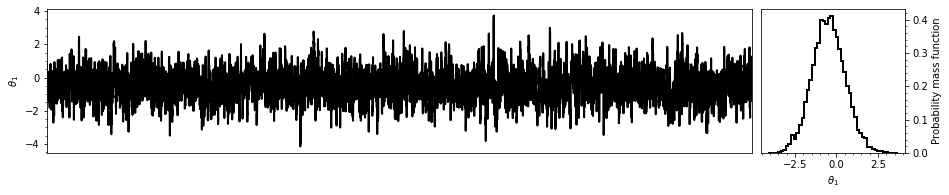

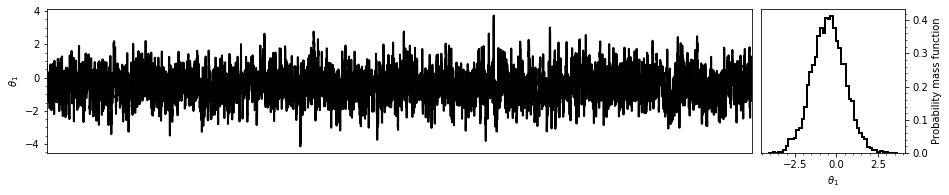

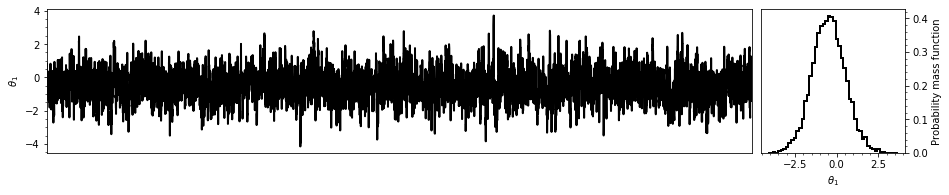

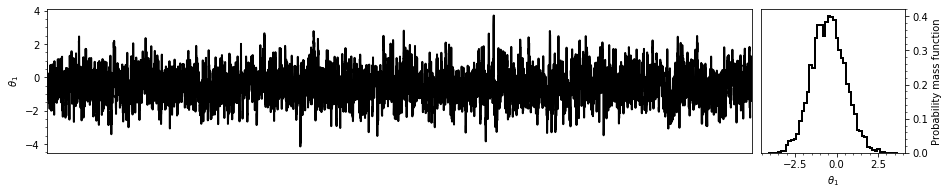

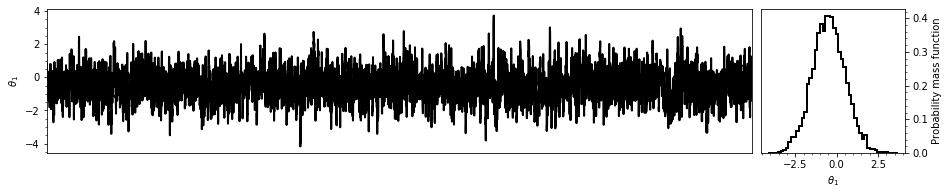

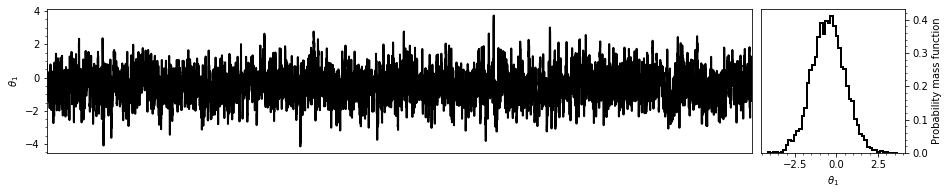

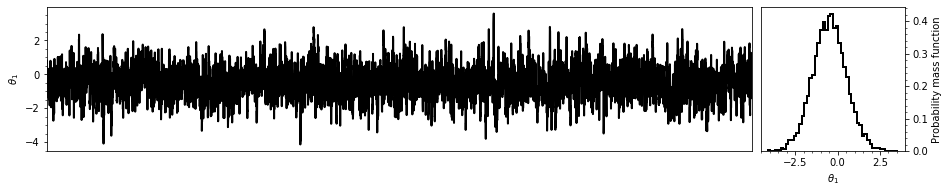

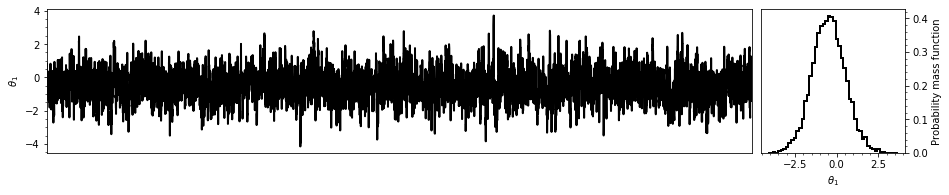

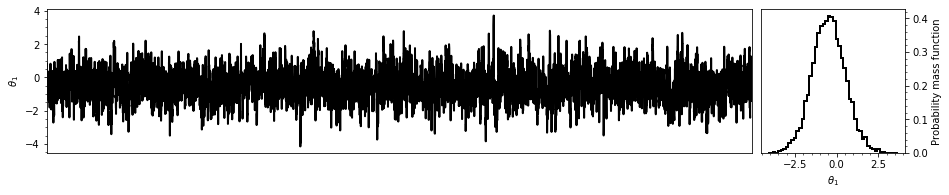

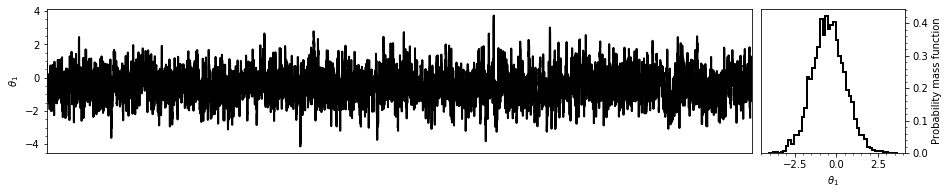

In [14]:
burnin_chains = ensemble_sampler.sample(observations, num_samples=200)
thetas = [chain[-1] for chain in burnin_chains]
chains = ensemble_sampler.sample(observations, thetas=thetas, num_samples=10000)
for chain in chains:
    plot_trace(chain)